## Gen AI Task

 Agent to effectively answer different types of questions over a larger set of documents in the ICT CoE (Cloud, Applications, Cyber Security).

These questions include the following:

- QA over a specific doc
- QA comparing different docs
- Summaries over a specific doc
- Comparing summaries between different docs

Architecture:

- setup a "document agent" over each Document: each doc agent can do QA/summarization within its doc
- setup a top-level agent over this set of document agents.
- Do tool retrieval and then do CoT over the set of tools to answer a question.


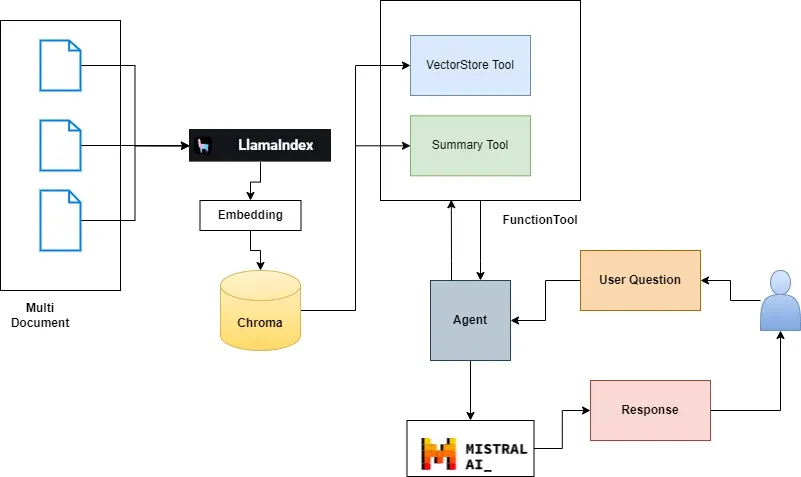

## Install

In [2]:
!pip install -qU  llama-index==0.10.64

In [3]:
!pip install -qU llama-index-core==0.10.64

In [4]:
!pip install -qU llama-index-embeddings-bedrock==0.2.0

In [5]:
!pip install -qU  llama-index-llms-bedrock==0.1.12

In [6]:
!pip install -qU llama-index-embeddings-huggingface==0.2.3

In [29]:
!pip install -qU llama-index-vector-stores-chroma==0.1.10

## Setup

In [51]:
import nest_asyncio

nest_asyncio.apply()

In [70]:
import logging
import boto3

from llama_index.core import SimpleDirectoryReader, ServiceContext

from llama_index.core import StorageContext, SimpleKeywordTableIndex
from llama_index.core import SummaryIndex,load_index_from_storage
from llama_index.core import VectorStoreIndex,SummaryIndex

from llama_index.embeddings.bedrock import BedrockEmbedding
from llama_index.llms.bedrock import Bedrock

from llama_index.core.schema import IndexNode
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.callbacks import CallbackManager

## Instantiate the embedding model

In [71]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

## Instantiate the LLM

In [72]:
instruct_mistral7b_id="mistral.mistral-7b-instruct-v0:2"

instruct_mixtral8x7b_id="mistral.mixtral-8x7b-instruct-v0:1"
mistral_large_2402_id="mistral.mistral-large-2402-v1:0"
titan_embeddings_g1="amazon.titan-embed-text-v1"
titan_text_embeddings_v2="amazon.titan-embed-text-v2:0"


DEFAULT_MODEL=instruct_mistral7b_id
DEFAULT_EMBEDDINGS=titan_text_embeddings_v2
AWS_REGION="eu-west-1"


# from llama_index.embeddings.bedrock import BedrockEmbedding

# embed_model = BedrockEmbedding(model=DEFAULT_EMBEDDINGS,
#                                region_name=AWS_REGION)


from llama_index.llms.bedrock import Bedrock
from llama_index.core import Settings
from llama_index.core import VectorStoreIndex

import boto3  # AWS SDK for Python
boto3_bedrock = boto3.client("bedrock-runtime")

model_kwargs_mistral = {
    "temperature": 0.5,
    "top_p": 0.9,
    "top_k": 200,
    "max_tokens": 8192  # Max response length
}

# Initialize the Mistral model to formulate final answer from search results
llm = Bedrock(
    model=DEFAULT_MODEL,
    streaming=True,
    client=boto3_bedrock,
    model_kwargs=model_kwargs_mistral,
    region_name=AWS_REGION
)


In [73]:
from llama_index.core import Settings

Settings.llm = llm
Settings.chunk_size = 1024
Settings.embed_model = embed_model

## Load Data

In [74]:
import os

# Directory containing the PDF files
pdf_dir = "coe_data"

# List all PDF files in the directory
pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith('.pdf')]

# Dictionary to hold the loaded documents
docs = {}

# Load each PDF file
for file in pdf_files:
    title = os.path.splitext(file)[0]  # Extract the file name without the extension
    docs[title] = SimpleDirectoryReader(
        input_files=[os.path.join(pdf_dir, file)]
    ).load_data()


## Split the documents into chunks/nodes

Constructing Multi-Document Agents

Objective:

- build a document agent for each document
- define the top-level parent agent with an object index.


In [75]:
pdf_titles = [os.path.splitext(f)[0] for f in os.listdir(pdf_dir) if f.endswith('.pdf')] 

In [76]:
pdf_titles

['How to Sell AWS Services',
 'Endpoint Security Proposition - Refresher Slides',
 'Telematics Offering - Revised',
 'How to Sell Safaricom Cloud & Hosting']

1. Build Document Agent for each Document

In this section we define "document agents" for each document.

We define both a vector index (for semantic search) and summary index (for summarization) for each document. The two query engines are then converted into tools that are passed to an OpenAI function calling agent.

This document agent can dynamically choose to perform semantic search or summarization within a given document.

We create a separate document agent for each city.

In [78]:
import chromadb
from typing import List,Optional
from llama_index.core import load_index_from_storage, StorageContext
from llama_index.core.node_parser import SentenceSplitter

from llama_index.vector_stores.chroma import ChromaVectorStore

from llama_index.core.tools import FunctionTool,QueryEngineTool

from llama_index.core.vector_stores import MetadataFilters,FilterCondition

In [85]:
# Initialize ChromaDB
db = chromadb.PersistentClient(path="./chroma_db_co")
chroma_collection = db.get_or_create_collection("multidocument-agent")

# Create ChromaVectorStore
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

# Create a storage context using ChromaVectorStore
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Initialize the Node Parser
node_parser = SentenceSplitter()

# Build agents and query_engines dictionaries
agents = {}
query_engines = {}

# This is for the baseline
all_nodes = []

for idx, pdf_title in enumerate(pdf_titles):
    # Extract nodes from the document
    nodes = node_parser.get_nodes_from_documents(docs[pdf_title])
    all_nodes.extend(nodes)

    # Define the persistence directory
    persist_dir = f"./coe_multi/{pdf_title}"

    if not os.path.exists(persist_dir):
        # Build vector index using ChromaDB and persist it
        vector_index = VectorStoreIndex(nodes, storage_context=storage_context)
        vector_index.storage_context.persist(persist_dir=persist_dir)
    else:
        # Load vector index from ChromaDB
        vector_index = load_index_from_storage(
            StorageContext.from_defaults(persist_dir=persist_dir, vector_store=vector_store),
        )

    # Build summary index
    summary_index = SummaryIndex(nodes)

    # Define query engines
    vector_query_engine = vector_index.as_query_engine(llm=Settings.llm)
    summary_query_engine = summary_index.as_query_engine(llm=Settings.llm)

    # Define tools
    query_engine_tools = [
        QueryEngineTool(
            query_engine=vector_query_engine,
            metadata=ToolMetadata(
                name="vector_tool",
                description=(
                    "Useful for questions related to specific aspects of"
                    f" {pdf_title}."
                ),
            ),
        ),
        QueryEngineTool(
            query_engine=summary_query_engine,
            metadata=ToolMetadata(
                name="summary_tool",
                description=(
                    "Useful for any requests that require a holistic summary"
                    f" of EVERYTHING about {pdf_title}. For questions about"
                    " more specific sections, please use the vector_tool."
                ),
            ),
        )
    ]

    # Build agent
    agent = ReActAgent.from_tools(
        query_engine_tools,
        llm=llm,
        verbose=True,
        system_prompt=f"""\
You are CoE Assistant, a specialized CoE Sales Assistant agent for Safaricom PLC designed to assist sales and internal teams in answering audit questions about {pdf_title}.
You must ALWAYS use at least one of the tools provided when answering a question.
When necessary, apply the 5Cs criteria: condition, cause, consequence, corrective action plans, and recommendations to formulate your answers.
""",
    )

    # Store agent and query engine
    agents[pdf_title] = agent
    query_engines[pdf_title] = vector_index.as_query_engine(
        similarity_top_k=2
    )


In [104]:
# define tool for each document agent
all_tools = []
for pdf_title in pdf_titles:
    pdf_summary = (
        f"This content contains  information about {pdf_title}. Use"
        f" this tool if you want to answer any questions about {pdf_title}.\n"
    )
    doc_tool = QueryEngineTool(
        query_engine=agents[pdf_title],
        metadata=ToolMetadata(
            name=f"tool_{pdf_title}",
            description=pdf_summary,
        ),
    )
    all_tools.append(doc_tool)

## Setup the RAG Agent

## Build Retriever-Enabled OpenAI Agent

We build a top-level agent that can orchestrate across the different document agents to answer any user query.

This agent takes in all document agents as tools. This specific agent `RetrieverOpenAIAgent` performs tool retrieval before tool use (unlike a default agent that tries to put all tools in the prompt).

Here we use a top-k retriever, but we encourage you to customize the tool retriever method!


In [105]:
from llama_index.core.agent import ReActAgent

In [106]:
# define an "object" index and retriever over these tools
from llama_index.core import VectorStoreIndex
from llama_index.core.objects import ObjectIndex

obj_index = ObjectIndex.from_objects(
    all_tools,
    index_cls=VectorStoreIndex,
)

In [92]:
from llama_index.agent.openai import OpenAIAgent

top_agent = ReActAgent.from_tools(
    tool_retriever=obj_index.as_retriever(similarity_top_k=3),
    system_prompt=f"""\
You are CoE Assistant , a specialized CoE Sales Assistant agent for Safricom PLC designed to assist sales and internal teams in answering audit questions about {pdf_title}.
You must ALWAYS use at least one of the tools provided when answering a question;\
When necessary, apply the 5Cs criteria,condition, cause, consequence, corrective action plans, and recommendations to formulate your answers\

""",
    verbose=True,
)

## Define Baseline Vector Store Index

As a point of comparison, we define a "naive" RAG pipeline which dumps all docs into a single vector index collection.

We set the top_k = 4

In [94]:
base_index = VectorStoreIndex(all_nodes)
base_query_engine = base_index.as_query_engine(similarity_top_k=4)

## Running Example Queries

Let's run some example queries, ranging from QA / summaries over a single document to QA / summarization over multiple documents.

In [95]:
# should use Boston agent -> vector tool
response = top_agent.query("hey")

> Running step 8ebc866b-924f-4d2c-8c46-73263fcd1383. Step input: hey
Thought: The current language of the user is: english. I need to use a tool to help me answer the question.
Action: tool_Telematics
Action Input: {'input': 'What is Telematics Offering - Revised?'}
Observation: Error: No such tool named `tool_Telematics`.
> Running step 54154a7c-e298-49d5-8c7c-1e9034c4abf9. Step input: None
Thought: I cannot answer the question with the provided tools.
Answer: I'm sorry, I cannot answer that question with the tools I have been given. The tool "tool\_Telematics" does not exist. Could you please provide more context or clarify the question?


In [96]:
# baseline
response = base_query_engine.query(
    "hey,who are you"
)
print(str(response))

 I am an expert Q&A system designed to answer queries based on the provided context information without directly referencing it. I don't have a personal identity or the ability to directly interact with individuals. My purpose is to provide accurate and helpful responses to queries using the context information provided.


In [97]:
# should use Boston agent -> vector tool
response = top_agent.query("How do I conduct an initial sales conversation with a customer? ")

> Running step 179dc2c9-6981-48da-828d-a58d2dbd228e. Step input: How do I conduct an initial sales conversation with a customer? 
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: tool_How
Action Input: {'input': 'initial sales conversation with a customer'}
Observation: Error: No such tool named `tool_How`.
> Running step 65c0c0db-b766-4005-bc6e-8ac86520d303. Step input: None
Thought: I cannot answer the question with the provided tools.
Answer: To conduct an initial sales conversation with a customer, you should first introduce yourself and your company. Then, ask open-ended questions to understand their current situation, needs, and pain points. Listen actively and show empathy. Next, present your product or service and explain how it addresses their needs. Use case studies or success stories to build credibility. Finally, ask for the next steps in the sales process, such as a demo or a proposal.


In [98]:
print(response)

To conduct an initial sales conversation with a customer, you should first introduce yourself and your company. Then, ask open-ended questions to understand their current situation, needs, and pain points. Listen actively and show empathy. Next, present your product or service and explain how it addresses their needs. Use case studies or success stories to build credibility. Finally, ask for the next steps in the sales process, such as a demo or a proposal.


In [99]:
# baseline
response = base_query_engine.query(
    "What have we got to say about Safaricom Cloud & Hosting Services?"
)
print(str(response))

 Safaricom offers enterprise-class cloud and hosting solutions that enable organizations to manage their computing and data growth while taking advantage of a more flexible and cost-efficient IT infrastructure. They provide a range of services including Co-location, Private Cloud, Flexible Computing, and Storage, all with government-grade security and professional services for assessment and implementation. Their cloud and hosting services have been helping clients improve their IT investment for over 8 years and offer simplified services and procurement, lower latency and cost secure connectivity, and managed services. They also have a team of qualified cloud practitioners to support customers through their cloud implementation journeys.


In [101]:
# should use Houston agent -> vector tool
response = top_agent.query(
    "What is Endpoint Security?"
)
print(response)

> Running step a17faab7-8473-4fb7-bbeb-2b4bdbe3db71. Step input: What is Endpoint Security?
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: tool_Endpoint
Action Input: {'input': 'What is Endpoint Security?'}
Observation: Error: No such tool named `tool_Endpoint`.
> Running step 65796e6e-627b-4b05-81dd-87a712bfc576. Step input: None
Thought: I cannot answer the question with the provided tools.
Answer: Endpoint security refers to security measures taken to protect endpoints on a computer network, such as laptops, desktops, tablets, and smartphones, from various threats. These threats include malware, hackers, and other cyber attacks. Endpoint security solutions often include antivirus software, firewalls, intrusion detection systems, and encryption technologies.
Endpoint security refers to security measures taken to protect endpoints on a computer network, such as laptops, desktops, tablets, and smartphones, from variou

In [102]:
# baseline
response = base_query_engine.query(
    "What is public cloud"
)
print(str(response))

 Public cloud is a type of computing environment where a service provider makes resources, such as virtual machines, applications, or storage, available to multiple clients over the internet. It offers businesses flexibility, cost savings, and the ability to quickly scale resources as needed. Public clouds are globally consistent, highly available, and can be easily connected to, making them an effective solution for businesses looking to expand into new geographies or reduce IT spend. They also offer cost efficiency, ease of deployment, and access to trusted IT expertise. Public clouds can be deployed within days and provide high availability, complying with international security standards while reducing operational risk and simplifying cloud management.


In [103]:
response = top_agent.query(
    "We are currently conducting an initial sales conversation with a customer. Please formulate a guideline on how to approach the initial sales conversation and and how to do the reporting."
)
print(response)

> Running step 0ec0757f-1936-4e33-88f8-4279fb83fde2. Step input: We are currently conducting an initial sales conversation with a customer. Please formulate a guideline on how to approach the initial sales conversation and and how to do the reporting.
Thought: The current language of the user is: English. I need to use a tool to help me answer the question about how to approach the initial sales conversation and how to do the reporting for AWS services.
Action: tool_How
Action Input: {'input': 'approach for initial sales conversation and reporting'}
Observation: Error: No such tool named `tool_How`.
> Running step 0dd82b7a-548a-495a-9645-be9231d563a5. Step input: None
Thought: I cannot answer the question with the provided tools.
Answer: To approach an initial sales conversation for AWS services, it's important to first understand the customer's business needs and objectives. You can ask open-ended questions to gather information about their current infrastructure, pain points, and goa